# Model Inference 

Script Functionalities- 
1. Downloads the random picture from the given URls
2. Loads the data and saved H5 model
3. Inference on random downloaded test samples  
4. Returns the most similar image to sample S from the training data set

## Initialization

In [1]:
import urllib
import os
import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

## JSON Parser

In [2]:
configfile = './config.json'
with open(configfile) as read_buffer:
    config_file = json.loads(read_buffer.read())
    image_H = config_file["input_H"]
    image_W = config_file["input_W"]
    urls = config_file["urls"]
    model_path = config_file["saved_model"]
    train_path = config_file["train_path"]
    
    

## Infering the URLs and generating similar images

Random picture from each of the given URLs,  running the below cell each time, downloads new images as the urls give random new images 

In [3]:
# Downloading the images from the urls. 
def download_urls(urls):
    for i, url in enumerate(urls):
        with urllib.request.urlopen(url) as url:
            save_path = os.getcwd() 
            completeName = os.path.join(save_path, 'inference_data/' + str(i) + '/'+ str(i)+'.jpg')         
            with open( completeName, 'wb') as f:
                f.write(url.read())

download_urls(urls)
print('download completed')

download completed


### Model load

In [4]:
model=load_model(model_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Data load

In [5]:
# test data loading
test_datagen = ImageDataGenerator(rescale=1. / 255)

url_gen = test_datagen.flow_from_directory('inference_data/',
                                           target_size=(image_H, image_W),
                                           batch_size=1, shuffle=False,
                                           class_mode='categorical')

# train data loading
train_gen = test_datagen.flow_from_directory(
        'data/train',
        target_size=(image_H, image_W),
        batch_size=1,
        shuffle=False,
        class_mode='categorical')


# method to display loaded images
def load_an_image(file_name):
    img = image.load_img(file_path, color_mode='rgb', target_size=(image_H, image_W))
    return img


Found 3 images belonging to 3 classes.
Found 706 images belonging to 3 classes.


### Inference 

car predictions: Audi:0.23753585%, Benz:0.326881%, Bmw:0.43558323%


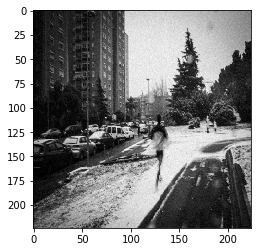

car predictions: Audi:0.55952924%, Benz:0.2608823%, Bmw:0.1795885%


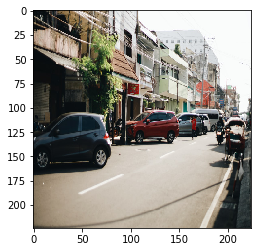

car predictions: Audi:0.39753208%, Benz:0.44006163%, Bmw:0.16240633%


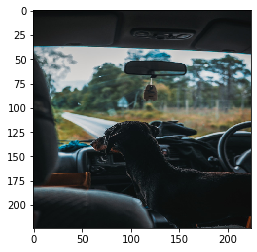

In [6]:
#Prediction
preds = model.predict(url_gen)

for i in range(len(url_gen)):

    print('car predictions: Audi:{}%, Benz:{}%, Bmw:{}%'.format(np.array2string(preds[i][0]),
                                                                   np.array2string(preds[i][1]),
                                                                   np.array2string(preds[i][2])))
    
    file_path = os.path.join(os.getcwd() + '/inference_data',  url_gen.filenames[i])
    im = load_an_image(file_path)
    plt.imshow(im)
    plt.show()

## Test Image similarity from train dataset

### cosine similarity

K(X, Y) = X . Y / (||X||*||Y||)

#### Steps:

1. Obtain the vector from flatten layer
2. Compute the prediction for all the trainset (X1, X2, ......Xn) 
3. Compute cosine similarity between samples S and train image Xn, append the cost distance in a array
4. Repeat the step(3) i.e, compute cost distance of samples S with all the trainset Xn
5. Sort the array in ascending order, min cost distance will be the most likely similar to the sample S


In [7]:
# Obtain the vector from flatten layer
test_image_sample = 1 
layer_name = 'dense_vector'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_train_preds = intermediate_layer_model.predict(train_gen)
intermediate_test_preds =  intermediate_layer_model.predict(url_gen)

# unit test to check the same channels between layer and predictions
assert intermediate_test_preds.shape[1] == 128

In [8]:
# simialrity check 
def similar_images(find_similar):
    error_dist= []
    for index, pred in enumerate(intermediate_train_preds):
        dist = cosine_similarity([find_similar],[pred])
        error_dist.append(dist)
    distance_arr = np.array(error_dist).reshape(-1)
    similar_images =np.argsort(distance_arr)[::-1][:1]  
    return similar_images

similar_image = similar_images(intermediate_test_preds[test_image_sample])

## Data Visulation

Sample image S


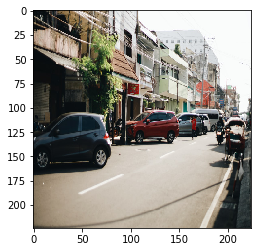

Most similar image to sample S from the training data set


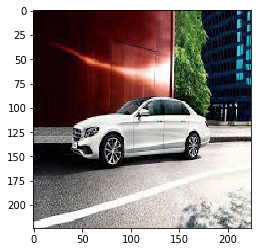

In [9]:
im_name = [train_gen.filenames[x] for x in similar_image]

print('Sample image S')
file_path = os.path.join(os.getcwd() + '/inference_data',  url_gen.filenames[test_image_sample])
im1 = load_an_image(file_path)
plt.imshow(im1)
plt.show()
print('Most similar image to sample S from the training data set')
file_path = os.path.join(os.getcwd() + '/data/train',  im_name[0])
im2 = load_an_image(file_path)
plt.imshow(im2)
plt.show()